# Final Project Report

# Introduction:

In [ ]:
#corey adds this part

# Methods & Results:

In [ ]:
#add method part and then perle will do the tune thing for knn 

In [4]:
set.seed(001)
library(tidyverse)
library(tidymodels)

players_url <- "https://raw.githubusercontent.com/coreyubc/project_individual/refs/heads/main/players.csv"

In [5]:
players <- read_csv(players_url)
head(players)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.

In [6]:
mean_player <- players |>
    summarize(playedhrs_avg = mean(played_hours), 
             Age_avg = mean(Age, na.rm = TRUE))
mean_player

playedhrs_avg,Age_avg
<dbl>,<dbl>
5.845918,20.52062


Questions:

We are targetting question 1: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

Particularly, we want to answer, whether the number of played hours and age can predict whether the player is subscribed to game-related newsletter.

Because the end goal is to use a predictive model (like knn classification, or regression), we want the two predictive variables to be comparable. I.e. They have to be the same data type (which is easier to compute), and that's why we have chosen them to be age and played hours.

FIRST!!! Remove rows with NA in Age and cap played_hours at 10 hours. 

In [103]:
players_clean <- players |>
  filter(!is.na(Age)) |>               
  mutate(played_hours_capped = pmin(played_hours, 10))

NEXT, let's select the 3 variables that are important to us and add it to a dataframe called unscaled_data.

In [90]:
unscaled_data <- players_clean |>
    select(Age, played_hours_capped, subscribe) |>
    as_tibble()

head(unscaled_data)

Age,played_hours_capped,subscribe
<dbl>,<dbl>,<lgl>
9,10.0,TRUE
17,3.8,TRUE
17,0.0,FALSE
21,0.7,TRUE
21,0.1,TRUE
17,0.0,TRUE


Next, we will have to change the data type from logical to factor and standardize the data points.

In [91]:
unscaled_data <- unscaled_data |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not_Subscribed" = "FALSE"))

head(unscaled_data)

Age,played_hours_capped,subscribe
<dbl>,<dbl>,<fct>
9,10.0,Subscribed
17,3.8,Subscribed
17,0.0,Not_Subscribed
21,0.7,Subscribed
21,0.1,Subscribed
17,0.0,Subscribed


Now we will use K-nn regression over linear regression as there is no clear linear trend. There is no assumptions here since it is clear that there is no significant linear relationship, which only leaves K-nn regression. A potential limitation or weakness of this method selected is it cannot distinguish whether a point is an outlier or not so we would have to eliminate the outliers first, which we have already done. In order to process the data to apply the model, we will split the data to 70/30 during the initial splitting. Then do cross-validation to determine the best K values. And then use that K value to predict.

First lets split the data 70/30 during the intial split using the unscaled data. Extract training set (70% of data) and extract test set (30% of data). 

In [92]:
player_split <- initial_split(unscaled_data, prop = 0.70, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

Cross validation to find the best k!

*Define preprocessing steps: scale and center predictors (Age, played_hours)*

In [93]:
recipe <- recipe(subscribe ~ played_hours_capped + Age, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

*Prepare (prep) the recipe using training data (calculates scaling factors), bake the recipe to training data and the the same scaling to test data (using training set's scaling factors)*

In [94]:
prepped_recipe <- prep(recipe, training = player_train)

train_scaled <- bake(prepped_recipe, new_data = player_train)

test_scaled <- bake(prepped_recipe, new_data = player_test)

Define KNN model with:
   - Rectangular weights 
   - Tuneable neighbors 
   - Use tune() for optimal k

In [95]:
knn_spec <- nearest_neighbor(weight_func = "rectangular",  neighbors = tune()) |>           
  set_engine("kknn") |> 
  set_mode("classification")

knn_workflow <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec)

cv_folds <- vfold_cv(player_train, v = 5)

k_grid <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(recipe) |>           
  add_model(knn_spec) |>         
  tune_grid(
    resamples = cv_folds,         
    grid = k_grid) |>
  collect_metrics()              

*Now filter to find the k that maximizes cross-validated accuracy.*

In [96]:
accuracies <- knn_results |>
  filter(.metric == "accuracy")   

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4814815,5,0.03098741,Preprocessor1_Model01
6,accuracy,binary,0.5333333,5,0.03813196,Preprocessor1_Model02
11,accuracy,binary,0.6000000,5,0.05418051,Preprocessor1_Model03
16,accuracy,binary,0.7185185,5,0.03008903,Preprocessor1_Model04
21,accuracy,binary,0.7333333,5,0.03954473,Preprocessor1_Model05
26,accuracy,binary,0.7333333,5,0.03954473,Preprocessor1_Model06
31,accuracy,binary,0.7333333,5,0.03954473,Preprocessor1_Model07
36,accuracy,binary,0.7333333,5,0.03954473,Preprocessor1_Model08
41,accuracy,binary,0.7333333,5,0.03954473,Preprocessor1_Model09


*Create a plot to look at visualize the differences between high k and low k. But most importantly to get k at the which is at the "elbow" of the curve.*

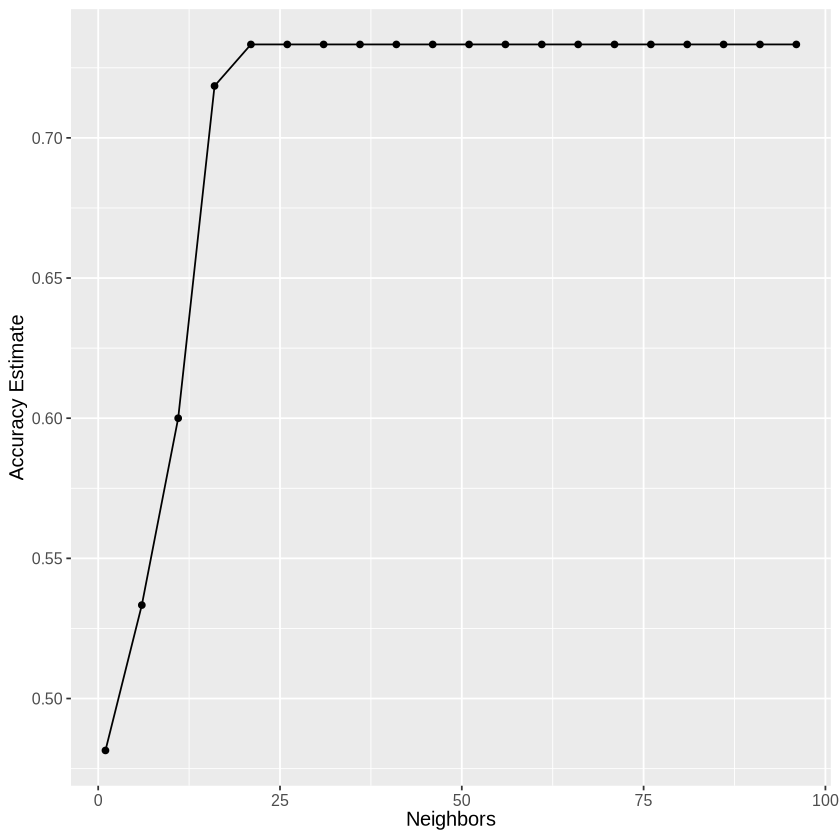

In [97]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

*To ensure we have chosen the correct k value we can also select k with highest mean accuracy
(from accuracies)*

In [98]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k #21 

[1] 21

Now we have found the best k we can test it out on our data!

In [99]:
playerbest_recipe <- recipe(subscribe ~ Age + played_hours_capped, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_wf <- workflow() |>
  add_recipe(playerbest_recipe) |>  # Preprocessing steps
  add_model(knn_spec)  

knn_fit <- knn_wf |> 
  fit(data = player_train)

knn_fit

test_predictions <- predict(knn_fit, new_data = player_test)

test_results <- player_test |> 
  bind_cols(test_predictions)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2444444
Best kernel: rectangular
Best k: 21

*Evaluate preformance*

In [100]:
conf_mat(test_results, truth = subscribe, estimate = .pred_class)
accuracy(test_results, truth = subscribe, estimate = .pred_class)

                Truth
Prediction       Not_Subscribed Subscribed
  Not_Subscribed              0          1
  Subscribed                 16         42

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7118644


*Okay there are a few problems including the fact that our confusion matrix shows us our predictive model failed to identify "Not_Subscribed" cases. It misclassified all 16 true "Not_Subscribed" users as "Subscribed" (false negatives). So our model that always guesses "Subscribed." We predict that this may have happened is because Age has no mathematical relationship with subscription status. So, our analysis found no evidence that age or playtime predict subscriptions.*

To double check it wasn't due to our model we checked the correlation. 

In [102]:
unscaled_data |>  
  mutate(subscribe_num = as.numeric(subscribe == "Subscribed")) |>  
  summarise(
    cor_hrs = cor(subscribe_num, played_hours_capped),  
    cor_age = cor(subscribe_num, Age)  
  )  

cor_hrs,cor_age
<dbl>,<dbl>
0.1409789,-0.2417285


Since its near 0 and actually negative for the Age variable we can conclude that we cannot use the predictors Age and played_hours to determind if a participant is subcribed.  

# Discussion: